In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import utils
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [3]:
df = pd.read_csv("data/NWOGrants.csv", sep=";")
df.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


In [4]:
df['discipline'] = df['discipline'].astype('category')
df['gender'] = df['gender'].astype('category')

In [5]:
coords = {
    "discipline_dim": df['discipline'].cat.categories,
    "gender_dim": df['gender'].cat.categories,
}
with pm.Model(coords=coords) as model1:
    awards = pm.MutableData("awards_data", df.awards)
    gender_idx = pm.MutableData("gender_data", df.gender.cat.codes)
    discipline_idx = pm.MutableData("discipline_data", df.discipline.cat.codes)
    applications = pm.MutableData("applications_data", df.applications)

    gender_bias = pm.Normal("gender_bias", mu=-1, sigma=1, dims="gender_dim")

    p = pm.math.sigmoid(gender_bias[gender_idx])

    awards_hat = pm.Binomial("awards_hat", n=applications, p=p, observed=awards)
    trace1 = pm.sample(2000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gender_bias]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [6]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gender_bias[f],-1.739,0.081,-1.897,-1.593,0.001,0.001,8333.0,5361.0,1.0
gender_bias[m],-1.533,0.064,-1.651,-1.410,0.001,0.001,8124.0,5213.0,1.0


array([[<AxesSubplot:title={'center':'gender_bias'}>]], dtype=object)

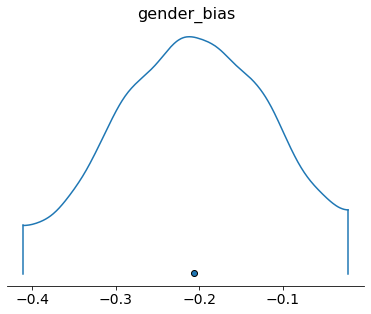

In [7]:
f = trace1.posterior["gender_bias"][..., 0]
m = trace1.posterior["gender_bias"][..., 1]
az.plot_density(f - m)

In [8]:
coords = {
    "discipline_dim": df['discipline'].cat.categories,
    "gender_dim": df['gender'].cat.categories,
}
with pm.Model(coords=coords) as model2:
    awards = pm.MutableData("awards_data", df.awards)
    gender_idx = pm.MutableData("gender_data", df.gender.cat.codes)
    discipline_idx = pm.MutableData("discipline_data", df.discipline.cat.codes)
    applications = pm.MutableData("applications_data", df.applications)

    gender_bias = pm.Normal("gender_bias", mu=-1, sigma=1, dims=("gender_dim", "discipline_dim"))

    p = pm.math.sigmoid(gender_bias[gender_idx, discipline_idx])
    p = pm.Deterministic("p", p)

    awards_hat = pm.Binomial("awards_hat", n=applications, p=p, observed=awards)
    trace2 = pm.sample(2000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gender_bias]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


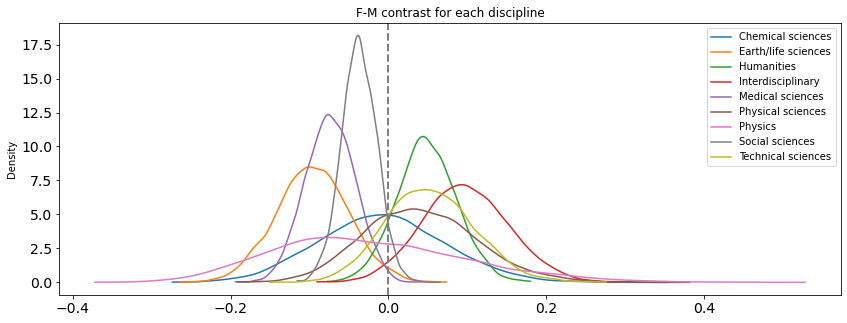

In [9]:
link = partial(utils.link, model2, trace2, gender_data=[0, 1], applications_data=[1, 1], var_names=["p"])
for i, discipline in enumerate(df.discipline.cat.categories):
    posterior = link(discipline_data=[i, i]).posterior_predictive["p"]
    f, m = posterior[..., 0],  posterior[..., 1]
    az.plot_dist(f - m, label=discipline, color=f"C{i}", figsize=(14,5))

plt.ylabel("Density")
plt.title("F-M contrast for each discipline")
plt.axvline(0, c="grey", lw=2, ls="dashed")

None

In [10]:
total_apps = df.applications.sum()
apps_per_discipline = df.applications.groupby(df.discipline).sum()

In [11]:
f = [0] * total_apps
m = [1] * total_apps
applications = [1]*total_apps
discipline = apps_per_discipline.index.codes.repeat(apps_per_discipline)

link = partial(utils.link, model2, trace2,
    applications_data=applications,
    discipline_data=discipline,
    var_names=["p"])

In [12]:
diff = link(gender_data=f).posterior_predictive - link(gender_data=m).posterior_predictive

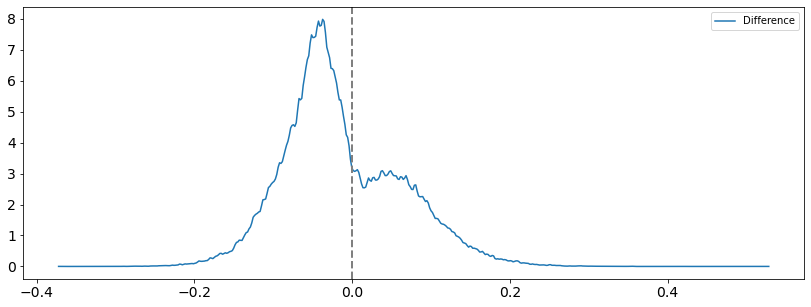

In [13]:
az.plot_dist(diff["p"], label="Difference", color="C0", figsize=(14,5))
plt.axvline(0, c="grey", lw=2, ls="dashed")

In [14]:
df.columns

Index(['discipline', 'gender', 'applications', 'awards'], dtype='object')

In [15]:
with model2:
    samples2 = pm.sample_posterior_predictive(trace2, var_names=["gender_bias"])

In [16]:
apps_per_gender = df.groupby(["discipline", "gender"]).applications.sum().unstack()
apps_per_gender = apps_per_gender / apps_per_gender.sum(axis=0)
apps_per_gender["f > m"] = apps_per_gender["f"] > apps_per_gender["m"]

gender_bias = trace2.posterior["gender_bias"]

f_bias = utils.sigmoid(gender_bias[:, :, 0, :].to_numpy()).mean(axis=(0,1))
m_bias = utils.sigmoid(gender_bias[:, :, 1, :].to_numpy()).mean(axis=(0,1))

apps_per_gender["f_bias"] = f_bias
apps_per_gender["m_bias"] = m_bias

apps_per_gender["f_bias > m_bias"] = f_bias > m_bias
apps_per_gender["bias_diff"] = (f_bias - m_bias).round(3)
apps_per_gender = apps_per_gender.merge(
    df.groupby(["discipline"]).awards.sum() / df.awards.sum(), left_index=True, right_index=True
)

d = df.groupby(["discipline"])[["applications", "awards"]].apply(lambda x: x.sum()) 
p_awards = d.apply(lambda row: row.awards / row.applications, axis=1)
p_awards.name = "p_awards"
apps_per_gender = apps_per_gender.merge(p_awards, left_index=True, right_index=True)
apps_per_gender

,f,m,f > m,f_bias,m_bias,f_bias > m_bias,bias_diff,awards,p_awards
discipline,,,,,,,,,
Chemical sciences,0.032828,0.050765,False,0.258194,0.265881,False,-0.008,0.068522,0.262295
Earth/life sciences,0.106061,0.095413,True,0.148503,0.244777,False,-0.096,0.119914,0.198582
Humanities,0.139731,0.140673,False,0.195519,0.147094,True,0.048,0.139186,0.164141
Interdisciplinary,0.065657,0.064220,True,0.221587,0.123515,True,0.098,0.062099,0.158470
Medical sciences,0.218855,0.149847,True,0.115853,0.189658,False,-0.074,0.160600,0.148515
Physical sciences,0.032828,0.082569,False,0.236847,0.195698,True,0.041,0.074946,0.201149
Physics,0.007576,0.040979,False,0.245506,0.268636,False,-0.023,0.042827,0.263158
Social sciences,0.344276,0.259939,True,0.117277,0.154530,False,-0.037,0.239829,0.134293
Technical sciences,0.052189,0.115596,False,0.215088,0.161847,True,0.053,0.092077,0.171315


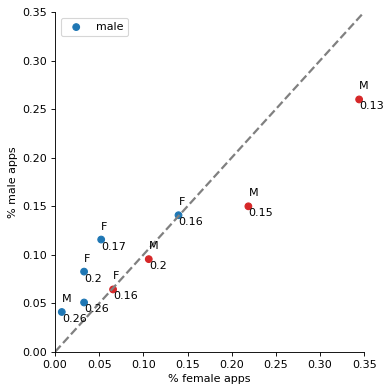

In [17]:
plt.figure(figsize=(5,5), dpi=80)

c = apps_per_gender["f > m"].map({True: "C3", False: "C0"})
text = apps_per_gender["f_bias > m_bias"].map({True: "F", False: "M"})
plt.scatter(apps_per_gender["f"], apps_per_gender["m"], c=c, label="male")

for _, row in  apps_per_gender.iterrows():
    gender = "F" if row.f_bias > row.m_bias else "M"
    award = round(row.p_awards, 2)
    plt.annotate(award, (row.f, row.m), xytext=(0, -10), textcoords="offset pixels")
    if abs(row.bias_diff) > 0.01:
        plt.annotate(gender, (row.f, row.m), xytext=(0, 10), textcoords="offset pixels")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.xlim(0, 0.35)
plt.xlabel("% female apps")
plt.ylim(0, 0.35)
plt.ylabel("% male apps")
plt.plot([0, 0.35], [0, 0.35], c="grey", lw=2, ls="dashed")
plt.tight_layout()
plt.legend()
        
